Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [8]:
%matplotlib inline

In [9]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [10]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [11]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from nn import *
import pickle

In [12]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state)


In [13]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

INFO (theano.gof.compilelock): Refreshing lock /Users/weichaozhou/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock


An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

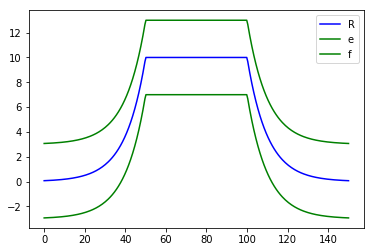

In [14]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))
    else:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))
      
posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1, 0, 0]], [[0, -1, 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [20, 20]
q2 = [0.01, 0.01]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])



Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [ ]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0] # Initial state.
# Random initial action path.
us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
#us_init = np.zeros((N, dynamics.action_size))

for i in range(0, int(N - n) + 1):
    print("Step %d" % i)
    if i % n != 0:
        #continue
        pass
    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x_path_.append(x0)
    expert_traj = expert_traj + [[x_path_, us[0]]]

    #expert_traj = expert_traj + [[xs[i], us[i]] for i in range(len(xs) - 1)]
    x0 = xs[1]

Step 0
iteration 0 accepted [672.76533975] [ 5.35067003  1.23999363 10.01980912  7.32722497]


The result can be visulized by executing the following code.

In [35]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][-1][0])
    posy.append(i[0][-1][1])
    v.append(i[0][-1][2])
    theta.append(i[0][-1][3])
    
    X_ = []
    for j in i[0]:
        for k in j:
            X_.append(k)
    X.append(X_)
    Y.append(i[1])


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

pickle.dump((X, Y), open('expert_traj.p', 'wb'))

1355


The red curve in this plot is the trajecotry of the MPC vehicle. 

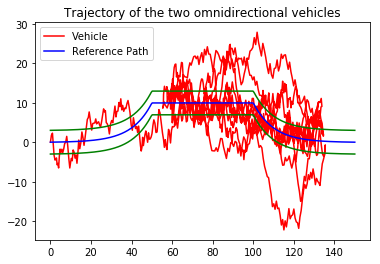

In [27]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [7]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_pts = []


num_pts = 50000
for pt in range(num_pts):
    x0 = [] # Initial state.
    i = random.randint(0, len(x_path) - n - 1)
    x0 = [x_path[i], \
          3.0 * (2 * random.random() - 1.0), \
          9.0 + 2 * random.random(), \
          5.0 * (2 * random.random() - 1.0)]
    
    # Random initial action path.
    us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
    #us_init = np.zeros((N, dynamics.action_size))
    print("Point %d" % pt)
    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x_path_.append(x0)
    expert_pts = expert_pts + [[x_path_, us[0]]]


SyntaxError: unexpected character after line continuation character (<ipython-input-7-4b8acfb62749>, line 10)

In [ ]:
X = []
Y = []

for i in expert_pts:
    X.append(i[0])
    Y.append(i[1])

pickle.dump((X, Y), open('expert_pts.p', 'wb'))

Now train a simple regression model to output control given the current coordinate.

In [31]:
agent = NeuralNetwork(input_size = 31 * 4)

agent.data_process(path = 'expert_pts.p')
agent.train(num_epoch = 100)


[1,     2] loss: 16.064
[1,    17] loss: 4.015
[1,    32] loss: 3.281
[1,    47] loss: 4.166
[1,    62] loss: 2.418
[1,    77] loss: 1.431
[1,    92] loss: 9.243
[1,   107] loss: 1.088
[1,   122] loss: 1.096
[2,     2] loss: 0.195
[2,    17] loss: 1.400
[2,    32] loss: 16.483
[2,    47] loss: 2.564
[2,    62] loss: 1.180
[2,    77] loss: 1.136
[2,    92] loss: 1.137
[2,   107] loss: 8.842
[2,   122] loss: 1.211
[3,     2] loss: 0.172
[3,    17] loss: 1.200
[3,    32] loss: 1.160
[3,    47] loss: 1.291
[3,    62] loss: 2.366
[3,    77] loss: 16.563
[3,    92] loss: 1.003
[3,   107] loss: 9.046
[3,   122] loss: 1.247
[4,     2] loss: 0.196
[4,    17] loss: 1.248
[4,    32] loss: 1.004
[4,    47] loss: 16.669
[4,    62] loss: 2.486
[4,    77] loss: 1.139
[4,    92] loss: 1.124
[4,   107] loss: 1.172
[4,   122] loss: 9.046
[5,     2] loss: 0.168
[5,    17] loss: 1.121
[5,    32] loss: 1.117
[5,    47] loss: 1.101
[5,    62] loss: 1.136
[5,    77] loss: 1.250
[5,    92] loss: 2.370
[5,   1

[39,   107] loss: 1.222
[39,   122] loss: 1.096
[40,     2] loss: 0.146
[40,    17] loss: 1.001
[40,    32] loss: 1.102
[40,    47] loss: 1.270
[40,    62] loss: 1.151
[40,    77] loss: 17.884
[40,    92] loss: 0.963
[40,   107] loss: 1.042
[40,   122] loss: 1.124
[41,     2] loss: 0.117
[41,    17] loss: 0.928
[41,    32] loss: 0.942
[41,    47] loss: 1.125
[41,    62] loss: 0.925
[41,    77] loss: 1.366
[41,    92] loss: 2.478
[41,   107] loss: 9.126
[41,   122] loss: 1.072
[42,     2] loss: 0.151
[42,    17] loss: 24.407
[42,    32] loss: 1.235
[42,    47] loss: 1.097
[42,    62] loss: 1.071
[42,    77] loss: 1.029
[42,    92] loss: 1.041
[42,   107] loss: 1.087
[42,   122] loss: 2.432
[43,     2] loss: 0.148
[43,    17] loss: 2.557
[43,    32] loss: 1.151
[43,    47] loss: 0.973
[43,    62] loss: 1.034
[43,    77] loss: 0.972
[43,    92] loss: 16.416
[43,   107] loss: 1.089
[43,   122] loss: 1.025
[44,     2] loss: 0.123
[44,    17] loss: 1.122
[44,    32] loss: 1.041
[44,    47] l

[78,    62] loss: 1.046
[78,    77] loss: 1.118
[78,    92] loss: 8.953
[78,   107] loss: 1.033
[78,   122] loss: 1.153
[79,     2] loss: 0.133
[79,    17] loss: 16.542
[79,    32] loss: 0.989
[79,    47] loss: 2.270
[79,    62] loss: 1.081
[79,    77] loss: 1.078
[79,    92] loss: 1.094
[79,   107] loss: 8.974
[79,   122] loss: 1.046
[80,     2] loss: 0.129
[80,    17] loss: 1.212
[80,    32] loss: 1.045
[80,    47] loss: 1.064
[80,    62] loss: 10.345
[80,    77] loss: 16.395
[80,    92] loss: 1.103
[80,   107] loss: 0.969
[80,   122] loss: 0.924
[81,     2] loss: 0.108
[81,    17] loss: 1.128
[81,    32] loss: 10.305
[81,    47] loss: 1.045
[81,    62] loss: 0.897
[81,    77] loss: 16.707
[81,    92] loss: 1.003
[81,   107] loss: 1.084
[81,   122] loss: 1.056
[82,     2] loss: 0.227
[82,    17] loss: 0.959
[82,    32] loss: 2.462
[82,    47] loss: 1.062
[82,    62] loss: 0.991
[82,    77] loss: 1.206
[82,    92] loss: 1.096
[82,   107] loss: 1.130
[82,   122] loss: 16.379
[83,     2

In [32]:

agent_traj = []
x0 = [x_path[0]]  # Initial state.
# Random initial action path.

N = 300
n = 30
for i in range(0, int(N - n) + 1):
    x_path_ = x_path[i: i + n]
    x = []
    for j in x_path_:
        for k in j:
            x.append(k)
    for j in x0[0]:
        x.append(j)

    u = agent.run([x])
    agent_traj = agent_traj + [[x[:], u[0]]]
    x0 = dynamics.f(x[-4: ], u[0], i)
    
    print(x0)

[[ 0.50021363  0.07074988 10.00899931  0.17815643]]
[[ 0.99300563  0.15948475 10.01969353  0.36358404]]
[[ 1.4615263   0.33775697 10.03194381  0.53857047]]
[[ 1.89240671  0.59520289 10.04536011  0.68139374]]
[[ 2.28279342  0.91179445 10.05964422  0.77948419]]
[[ 2.64081859  1.26560978 10.07459759  0.82750232]]
[[ 2.98196091  1.63676032 10.08995768  0.82305674]]
[[ 3.32527664  2.00695868 10.10558697  0.76918848]]
[[ 3.68858964  2.35868018 10.12130024  0.67713883]]
[[ 4.08330575  2.67600829 10.13694969  0.56178203]]
[[ 4.51258597  2.9462122  10.15262039  0.42521487]]
[[ 4.97536743  3.15577911 10.16820538  0.27947413]]
[[ 5.46442788  3.29613215 10.18386003  0.13291698]]
[[ 5.96952186  3.36366589 10.19969157 -0.01088261]]
[[ 6.47987901  3.35811165 10.21580324 -0.14604952]]
[[ 6.98564063  3.28371569 10.23235834 -0.26858853]]
[[ 7.47932778  3.14783366 10.24947489 -0.37611026]]
[[ 7.95639224  2.95943641 10.26721172 -0.46449001]]
[[ 8.41577223  2.72926248 10.28555032 -0.52968742]]
[[ 8.8599807

The red curve in the plot shows the trajectory of the regression model controller.

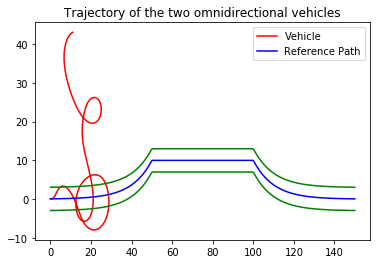

In [33]:

posx = []
posy = []
v = []
theta = []
for i in agent_traj:
    posx.append(i[0][-4])
    posy.append(i[0][-3])
    v.append(i[0][-2])
    theta.append(i[0][-1])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [ ]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.

x0 = x_path[0]  # Initial state.
# Random initial action path.
us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))

nn_traj = []
mpc_traj= []
traj = []

for i in range(N - n - 1):
    #print(">>>>>Step {} at {}".format(i, x0))
    u = agent.run([x0])
    #print("NN outputs control")
    agent_traj = agent_traj + [[x0, u[0, :]]]
    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = [20, 20], q2 = [0.01, 0.01], \
                   x_path = x_path_, \
                   x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0_, us_init, on_iteration=on_iteration)
    #print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[0,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        x0 = x0_[0]
        print("Utilize NN output")
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[0,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            xs, us = ilqr.fit(x0, us, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        x0 = xs[1]
        print("Utilize MPC output")

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

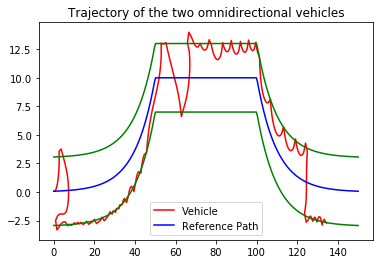

In [31]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])



The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

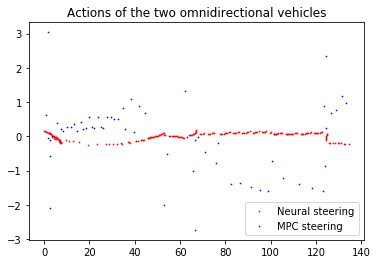

In [32]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 




<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
